In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Learning Libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
import seaborn as sns
from collections import Counter, defaultdict

Load Dataset and look at it

In [81]:
data = pd.read_csv("MAST_radiomics_clinical_data.csv")
#remove user id from data frame
df = data.drop(columns=['study_id', 'contribution_months', 'status','4kscore'])

#split train test 
from sklearn.model_selection import train_test_split
X = df
y = df.outcome.values.astype('int32')
X.drop(['outcome'], axis=1, inplace=True)
column = 'adc_min'

# Step 3: Calculate the average of the column excluding negative values
# Use boolean indexing to filter out negative values
positive_values = df[df[column] > 0][column]
average_value = positive_values.mean()

# Step 4: Replace negative values with the calculated average
df.loc[df[column] <= 0, column] = average_value
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, test_size=0.30, random_state=0)


   prostate_vol  lesion_count  total_lesion_vol     adc_mean     adc_min  \
0     48.993125             3          1.030000  1103.198043  631.599976   
1     26.050920             2          0.892920  1036.473071  563.831177   
2     92.462125             4          1.619625  1036.039573  863.860229   
3     32.327750             4          1.129625  1175.841112  588.787236   
4    116.396000             7          0.972125  1158.384901  839.992249   

       adc_max      adc_sd  adc_skew   adc_kurt      adc_10p  ...   dce_50p  \
0  1858.439941  232.550715  0.497482  -0.264728   810.439978  ...  1.397138   
1  1615.390747  171.229441  0.407404  -0.303378   842.470593  ...  1.050223   
2  1221.504761   75.261871  0.151853  -0.567523   939.823853  ...  2.218269   
3  1574.797974  154.126693 -3.259458  24.488103  1044.649414  ...  1.779869   
4  1591.943848  132.490154  0.093294  -0.445859   990.146851  ...  1.040919   

    dce_75p   dce_90p    psa  pirads_max   bmi  age  nccn  race  eth

In [11]:
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

2024-06-10 10:05:40.090103: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [82]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Example: Load your data
# df = pd.read_csv('your_data.csv')
# X = df.drop('target', axis=1)
# y = df['target']

# For demonstration, let's create some dummy data
# Assume you have 54 features in X and binary target variable y


# Initialize the model
model = RandomForestClassifier()

# Train the model
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame to hold feature names and their importance
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})

# Sort the DataFrame by importance in descending order
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Select the top 8 features
top_features = feature_importances.head(8)

print("Top 8 features:")
print(top_features)

Top 8 features:
         feature  importance
48    pirads_max    0.078116
6         adc_sd    0.042421
0   prostate_vol    0.041606
47           psa    0.039510
29      hbv_skew    0.030470
15       t2w_min    0.029251
8       adc_kurt    0.027861
51          nccn    0.027536


In [39]:
def roc(real_labels, predicted_probability):
    tpr = []
    fpr = []
    thresh=0.0


    #for i in range(0,100):
    #    sens_spec.append([])


    for i in range(100):
        nTruePos = 0
        nPos = 0
        nFalsePos = 0
        nNeg = 0
        for j, label in enumerate(real_labels):
            #print("real_labels[i] " + str(real_labels[j]))
            if (label == 1):   # if a cancer image
                nPos += 1
                if (predicted_probability[j] > thresh):     # if we predict cancer
                    nTruePos += 1
            else:                          # a non-cancer image
                nNeg += 1
                if (predicted_probability[j] > thresh):
                    nFalsePos += 1
#         print("thresh " + str(thresh) + " nTruePos " + str(nTruePos) + " nPos " + str(nPos) + " nFalsePos " + str(nFalsePos) + " nNeg " + str(nNeg))
        tpr.append( float(nTruePos) / float(nPos) )
        fpr.append( float(nFalsePos) / float(nNeg) )
        thresh+=0.01
    return tpr, fpr

In [59]:
def main(num):
    loss_results = []
    accuracy_results = []
    nn_auc_results = []
    threshold_results = []
    nn_fpr_results =[]
    nn_tpr_results = []
    for i in range(num):
        nn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(8, activation=tf.nn.relu, input_shape=(54,)),  # input shape required
        tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
        ])

        opt=Adam(learning_rate=0.001)

        nn_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        nn = nn_model.fit(X_train, y_train, epochs=1000, batch_size=10, verbose=0)
        loss, accuracy = nn_model.evaluate(X_test, y_test, verbose=0)
        loss_results.append(loss)
        accuracy_results.append(accuracy)
        predictions = nn_model.predict(X_test)
        neuralNetworkAUC = metrics.roc_auc_score(y_test, nn_model.predict(X_test))
        nn_auc_results.append(neuralNetworkAUC)
        fpr_NN, tpr_NN, threshold = metrics.roc_curve(y_test, nn_model.predict(X_test))
        nn_fpr_results.append(fpr_NN)
        nn_tpr_results.append(tpr_NN)
        threshold_results.append(threshold)
    return loss_results, accuracy_results, nn_auc_results, threshold_results, nn_fpr_results, nn_tpr_results

    #neural_network_AUC = metrics.roc_auc_score(y_test, nn.predict(X_test, batch_size=None, verbose=0)[:,1])
    #fpr_nn, tpr_nn, threshold = metrics.roc_curve(y_test, nn.predict(X_test, batch_size=None, verbose=0)[:,1])


In [60]:
#call the function
loss_results, accuracy_results, nn_auc_results, threshold_results, nn_fpr_results, nn_tpr_results = main(100)

2/2 [==============================] - 0s 1ms/step


In [72]:
def experiment(num, X, y):
    logistic_regression_results = []
    l_tpr = []
    l_fpr = []
    random_forest_results = []
    rf_tpr = []
    rf_fpr = []
    for i in range(num):
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)
        
        #Random Forest Classifier
        rf_model = RandomForestClassifier(n_estimators = 100, max_depth=5, random_state = 42)
        rf = rf_model.fit(X_train, y_train)
        predictions = rf.predict(X_test)
        #find ROC AUC curve
        randomForestAUC = metrics.roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
        fpr_RF, tpr_RF, threshold = metrics.roc_curve(y_test, rf.predict_proba(X_test)[:,1])
        random_forest_results.append(randomForestAUC)
        rf_tpr.append(tpr_RF)
        rf_fpr.append(fpr_RF)
        #Logistic regression
        l_model = LogisticRegression(solver='lbfgs')
        log = l_model.fit(X_train, y_train)
        predictions = log.predict(X_test)
        #find roc auc curve
        logisticRegressionAUC = metrics.roc_auc_score(y_test, log.predict_proba(X_test)[:,1])
        fpr_log, tpr_log, threshold = metrics.roc_curve(y_test, log.predict_proba(X_test)[:,1])
        logistic_regression_results.append(logisticRegressionAUC)
        l_tpr.append(tpr_log)
        l_fpr.append(fpr_log)
    
    #return random_forest_results, rf_tpr, rf_fpr
    return logistic_regression_results, l_tpr, l_fpr, random_forest_results, rf_tpr, rf_fpr

In [74]:
logistic_regression_results, l_tpr, l_fpr, rf_result, rf_tpr_1, rf_fpr_1 = experiment(1000, X, y)

/opt/anaconda3/envs/prostate/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/prostate/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

In [61]:
print(max(nn_auc_results))

0.8656462585034014


dict_keys(['loss', 'accuracy'])


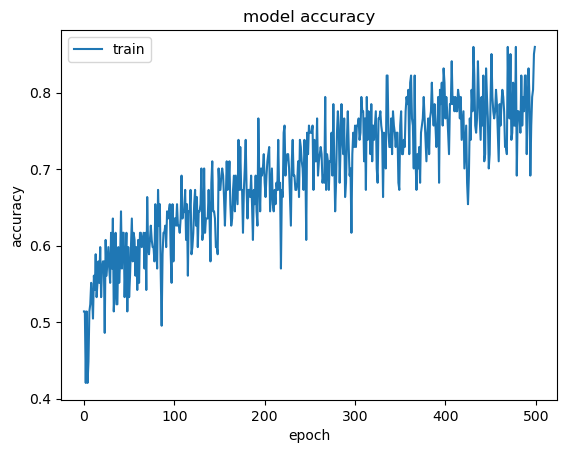

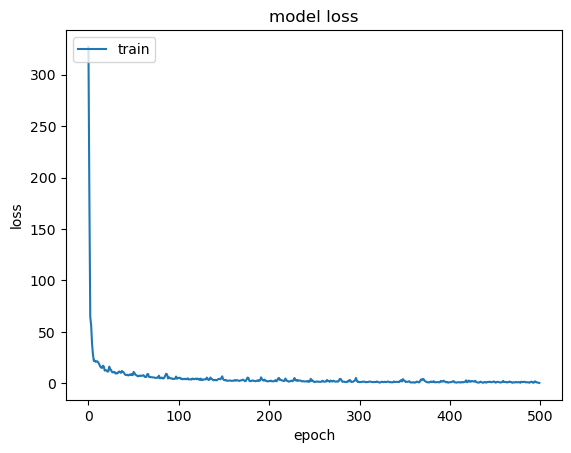

In [62]:
print(nn.history.keys())
# summarize history for accuracy
plt.plot(nn.history['accuracy'])
#plt.plot(nn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(nn.history['loss'])
#plt.plot(nn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[]

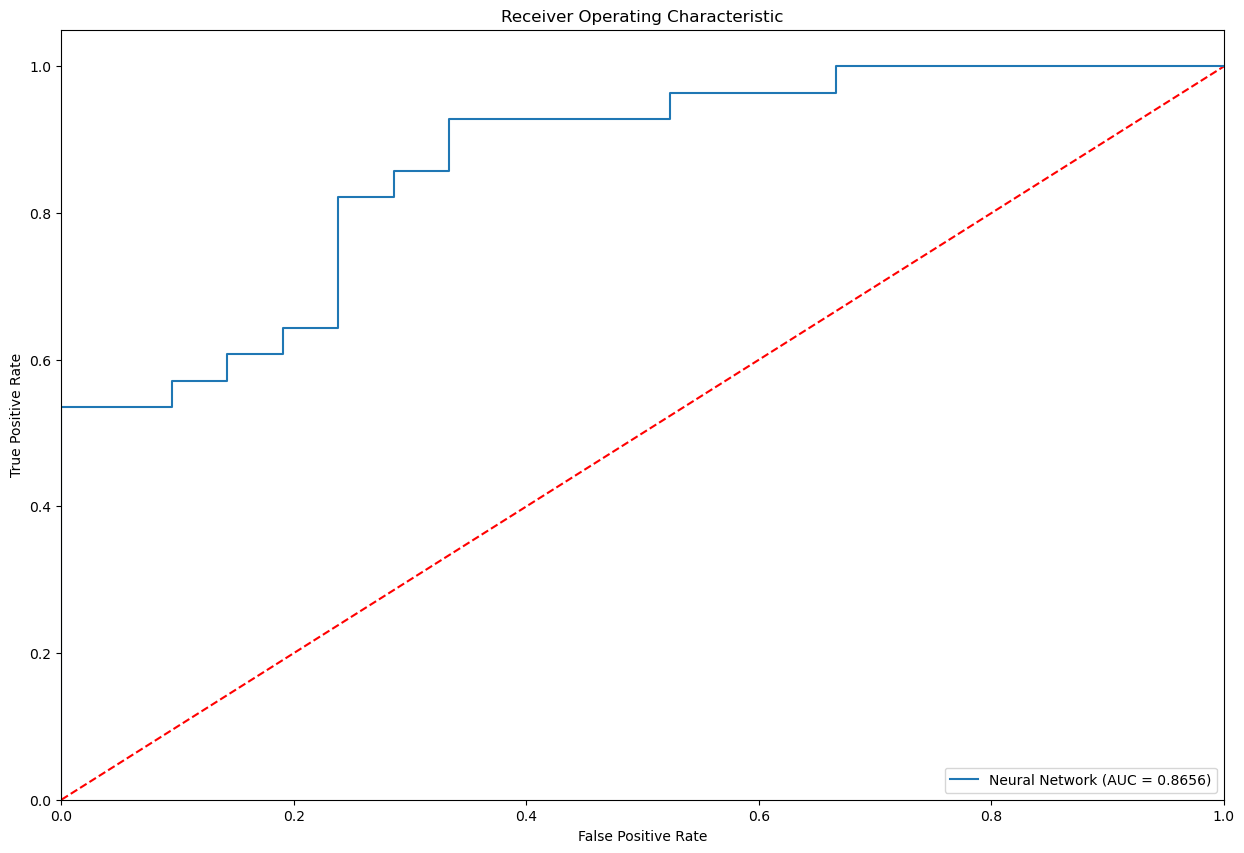

In [70]:
max_non_linear_index = nn_auc_results.index(max(nn_auc_results))
plt.figure(figsize=(15,10))
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.plot(nn_fpr_results[max_non_linear_index], nn_tpr_results[max_non_linear_index], label='Neural Network (AUC = %0.4f)' % max(nn_auc_results))
plt.legend(loc='lower right')
plt.plot()

In [75]:
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
max_linear_index = logistic_regression_results.index(max(logistic_regression_results))
max_non_linear_index = rf_result.index(max(rf_result))
max_nn_index = nn_auc_results.index(max(nn_auc_results))
# Define a new set of points to interpolate
x_new = np.linspace(0, 1, 100)

# Create interpolation functions
fpr_interp = interp1d(rf_fpr_1[max_non_linear_index], rf_tpr_1[max_non_linear_index], kind='linear')

# Apply interpolation to get smooth values
tpr_smooth = fpr_interp(x_new)

# Define a new set of points to interpolate
x_new = np.linspace(0, 1, 100)

# Create interpolation functions
fpr_interp = interp1d(l_fpr[max_linear_index], l_tpr[max_linear_index], kind='linear')

# Apply interpolation to get smooth values
l_tpr_smooth = fpr_interp(x_new)
# Define a new set of points to interpolate
x_new = np.linspace(0, 1, 100)

# Create interpolation functions
fpr_interp = interp1d(nn_fpr_results[max_linear_index], nn_tpr_results[max_linear_index], kind='linear')

# Apply interpolation to get smooth values
nn_tpr_smooth = fpr_interp(x_new)

[]

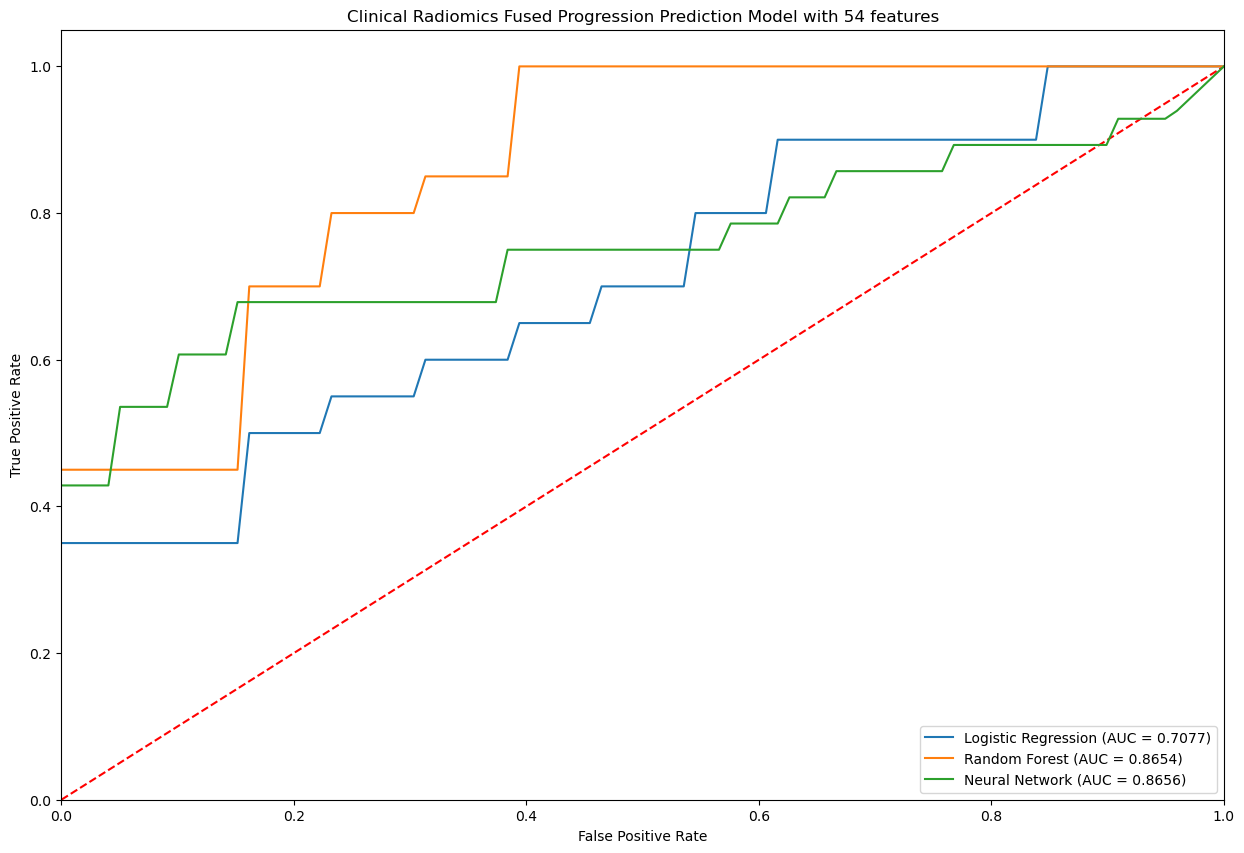

In [78]:
#Roc Auc Logistic and Random Forest Smooth
# ROC plot for max AUC Logistic and Random Forest
max_linear_index = logistic_regression_results.index(max(logistic_regression_results))
max_non_linear_index = rf_result.index(max(rf_result))
max_nn_index = nn_auc_results.index(max(nn_auc_results))
plt.figure(figsize=(15,10))
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Clinical Radiomics Fused Progression Prediction Model with 54 features')
plt.plot(x_new, l_tpr_smooth, label='Logistic Regression (AUC = %0.4f)' % max(logistic_regression_results))
plt.plot(x_new, tpr_smooth, label='Random Forest (AUC = %0.4f)' % max(rf_result))
plt.plot(x_new, nn_tpr_smooth, label='Neural Network (AUC = %0.4f)' % max(nn_auc_results))
plt.legend(loc='lower right')
plt.plot()

In [79]:
print('average AUC for random forest is:', sum(rf_result)/len(rf_result))
print('Max AUC for random forest is:', max(rf_result))
print('average AUC for logistic regression is:', sum(logistic_regression_results)/len(logistic_regression_results))
print('Max AUC for logistic regression is:', max(logistic_regression_results))
print('average AUC for Neural Networks is:', sum(nn_auc_results)/len(nn_auc_results))
print('Max AUC for Neural Networks is:', max(nn_auc_results))

average AUC for random forest is: 0.8653846153846333
Max AUC for random forest is: 0.8653846153846154
average AUC for logistic regression is: 0.7076923076923158
Max AUC for logistic regression is: 0.7076923076923077
average AUC for Neural Networks is: 0.6770748299319729
Max AUC for Neural Networks is: 0.8656462585034014
